### 파이프라인

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def pipeline(model,cut_off_values=None):

    data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/EDA/pure_budo.csv')
    data.drop(['loan_status', 'ym', 'DATE_x', 'grade', 'sub_grade', 'Unnamed: 0','DATE_y', 'fico_range_low', 'emp_length' ], axis=1, inplace=True)

    selected_variables = [
        'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_high',
        'mths_since_last_delinq', 'revol_bal', 'revol_util', 'total_acc', 'acc_open_past_24mths',
        'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_il_tl',
        'num_rev_accts', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
        'total_il_high_credit_limit', 'GS2', 'UNRATE', 'term', 'collections_12_mths_ex_med',
        'chargeoff_within_12_mths', 'tax_liens' ,'id','defaulter'
    ]
    data = data[selected_variables]

    raw_data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/raw_raw/lending_club_2020_train.csv')
    raw_data['defaulter'] = raw_data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else (1 if x != 'Current' else None))
    raw_data.dropna(subset=['defaulter'], inplace=True)

    # 범주형 변수, 원핫인코딩
    from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
    categorical_columns = data.select_dtypes(include=['object']).columns # 범주형 변수만을 선택
    one_hot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
    dummy_variables = one_hot_encoder.fit_transform(data[categorical_columns]) # 범주형 변수를 더미 변수로 변환
    dummy_df = pd.DataFrame(dummy_variables.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns)) # 더미 변수를 데이터프레임으로 변환

    data_final = pd.concat([data, dummy_df], axis=1)

    #상환 기록을 추적할 id 준비
    a = data['id']
    data_final['id'] = a
    add_column = data['defaulter']
    data_final['defaulter'] = add_column

    # 최종 훈련 데이터 준비 완료.
    x = data_final.drop('defaulter', axis=1)
    y = data_final['defaulter']

    # 리스트 초기화
    roe_values = []
    figure = []

    #본격 모델 학습

    if cut_off_values is None:
        cut_off_values = np.arange(0.1, 0.9, 0.01)  # 컷오프: 0.1부터 0.9까지 0.01씩 증가

    stk = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

    for cut_off in cut_off_values:

        roe_fold = []  # 폴드별 ROE를 저장할 리스트
        accuracy_fold = []  # 폴드별 정확도를 저장할 리스트 추가
        precision_fold = []  # 폴드별 정밀도를 저장할 리스트 추가
        recall_fold = []  # 폴드별 재현율을 저장할 리스트 추가
        f1_fold = []  # 폴드별 F1 스코어를 저장할 리스트 추가

        for train_index, test_index in stk.split(x, y):
            print("Train:", train_index, "Test:", test_index)
            Xtrain_id, Xtest_id = x.iloc[train_index], x.iloc[test_index]
            ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
            Xtrain = Xtrain_id.drop('id', axis=1)
            Xtest = Xtest_id.drop('id', axis=1)


            if model == 'logi':
                model = LogisticRegression(random_state=None, C=0.9025639567934765)

            elif model == 'ranfo':
                  model = RandomForestClassifier(random_state=None,
                                    max_depth=10,
                                    max_features='auto',
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    n_estimators=50)

            elif model == 'xgb':
                  model = XGBClassifier(random_state=None,
                          colsample_bytree=0.7780039838174233,
                          gamma=0.0,
                          learning_rate=0.02008483638376569,
                          max_depth=9,
                          min_child_weight=8,
                          n_estimators=649,
                          subsample=0.7364252164199087)

            elif model == 'lgbm':
                  warnings.filterwarnings("ignore", category=UserWarning)
                  model = LGBMClassifier(learning_rate=0.1, metric='binary_logloss', max_depth=-1, min_child_samples=560, num_leaves=1995,
                        n_estimators=100, force_col_wise=True, scale_pos_weight = 4.170821627484008, verbosity=-1)



            #실수 변수 : MinMax Scaling
            mod = make_pipeline(MinMaxScaler(), model)
            mod.fit(Xtrain, ytrain)

            #컷오프를 기준으로 분류
            probability = mod.predict_proba(Xtest)[:, 1]
            cutoff = cut_off
            prediction = (probability >= cutoff).astype(int)


            # 평가 지표 계산
            accuracy = accuracy_score(ytest, prediction)
            precision = precision_score(ytest, prediction)
            recall = recall_score(ytest, prediction)
            f1 = f1_score(ytest, prediction)
            confusion = confusion_matrix(ytest, prediction)


            #모든 분류결과에 기존 존재하던 ID 부여 : (전체 Xtest 대상)
            result = pd.DataFrame({'id': Xtest_id['id'], 'defaulter_prediction': prediction, 'defaulter_probability': probability})

            #ID를 기준으로, 분류결과 + raw_data
            merged_df = pd.merge(result, raw_data, on='id', how='inner')
            merged_df['term'] = merged_df['term'].str.extract('(\d+)').astype(float)

            #all_loan : 대출 승인된 모든 경우 : (분류기가 모두 '비부도' 라고 예측한 경우, TP + FN)
            all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                                     (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

            #기간 계산
            all_loan['last_pymnt_d'] = pd.to_datetime(all_loan['last_pymnt_d'], format='%b-%Y')
            all_loan['issue_d'] = pd.to_datetime(all_loan['issue_d'], format='%b-%Y')
            all_loan['paid_months'] = (all_loan['last_pymnt_d'] - all_loan['issue_d']) / pd.Timedelta(days=30)
            all_loan.loc[all_loan['paid_months'] == 0, 'paid_months'] = 1

            #평균 상환기간 계산 & 연 단위 변경
            avg_paid_year = all_loan['paid_months'].mean()/12

            #ROE 계산
            roe = ((all_loan['total_pymnt'].sum() - all_loan['funded_amnt'].sum()) / avg_paid_year) / all_loan['funded_amnt'].sum()

            #폴드별 ROE, 성능지표 저장
            roe_fold.append(roe)  # 폴드별 ROE 저장
            accuracy_fold.append(accuracy)
            precision_fold.append(precision)
            recall_fold.append(recall)
            f1_fold.append(f1)

        # 특정 컷오프 내, 폴드의 평균 지표 저장
        roe_mean = np.mean(roe_fold)
        accuracy_mean = np.mean(accuracy_fold)
        precision_mean = np.mean(precision_fold)
        recall_mean = np.mean(recall_fold)
        f1_mean = np.mean(f1_fold)
        print('cut_off',[cut_off])
        print('mean roe',[roe_mean])

        figure_df = pd.DataFrame({'Cut Off:': [cut_off],
                                  'ROE:' : [roe_mean],
                                  'Accuracy:' : [accuracy_mean],
                                  'Precision:': [precision_mean],
                                  'Recall:': [recall_mean],
                                  'F1:': [f1_mean],
                                      })


        figure.append(figure_df)
        roe_values.append(roe_mean)

    result_df = pd.concat(figure, ignore_index=True)

    plt.plot(cut_off_values, roe_values)
    plt.xlabel('Cutoff')
    plt.ylabel('ROE')
    plt.title('Cutoff & ROE')
    plt.grid(True)
    plt.show()

    return result_df

### LGBM_Validation

Train: [      1       5       6 ... 1078520 1078521 1078522] Test: [      0       2       3 ... 1078509 1078510 1078514]
Train: [      0       2       3 ... 1078509 1078510 1078514] Test: [      1       5       6 ... 1078520 1078521 1078522]
cut_off [0.1]
mean roe [0.03615903752242851]
Train: [      0       2       3 ... 1078517 1078519 1078521] Test: [      1       4       5 ... 1078518 1078520 1078522]
Train: [      1       4       5 ... 1078518 1078520 1078522] Test: [      0       2       3 ... 1078517 1078519 1078521]
cut_off [0.11]
mean roe [0.036023036515171844]
Train: [      0       2       3 ... 1078514 1078515 1078517] Test: [      1       6       8 ... 1078520 1078521 1078522]
Train: [      1       6       8 ... 1078520 1078521 1078522] Test: [      0       2       3 ... 1078514 1078515 1078517]
cut_off [0.12]
mean roe [0.03635083019131753]
Train: [      1       2       5 ... 1078518 1078519 1078520] Test: [      0       3       4 ... 1078516 1078521 1078522]
Train: [      0

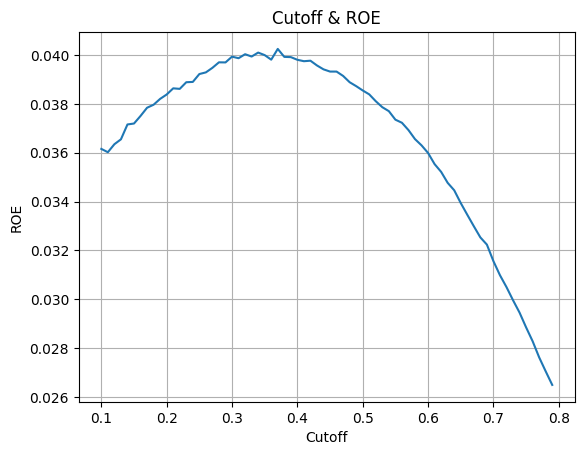

Train: [      3       8      10 ... 1078518 1078520 1078521] Test: [      0       1       2 ... 1078517 1078519 1078522]
Train: [      0       1       2 ... 1078517 1078519 1078522] Test: [      3       8      10 ... 1078518 1078520 1078521]
cut_off [0.1]
mean roe [0.035652711602211534]
Train: [      1       4       7 ... 1078520 1078521 1078522] Test: [      0       2       3 ... 1078515 1078516 1078517]
Train: [      0       2       3 ... 1078515 1078516 1078517] Test: [      1       4       7 ... 1078520 1078521 1078522]
cut_off [0.11]
mean roe [0.036180771336408776]
Train: [      1       2       5 ... 1078511 1078514 1078516] Test: [      0       3       4 ... 1078520 1078521 1078522]
Train: [      0       3       4 ... 1078520 1078521 1078522] Test: [      1       2       5 ... 1078511 1078514 1078516]
cut_off [0.12]
mean roe [0.03627566206162965]
Train: [      2       4       5 ... 1078516 1078519 1078520] Test: [      0       1       3 ... 1078518 1078521 1078522]
Train: [      

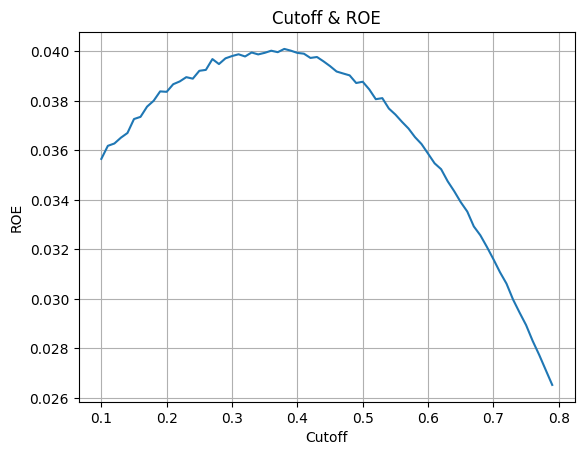

Train: [      4       5       7 ... 1078519 1078521 1078522] Test: [      0       1       2 ... 1078517 1078518 1078520]
Train: [      0       1       2 ... 1078517 1078518 1078520] Test: [      4       5       7 ... 1078519 1078521 1078522]
cut_off [0.1]
mean roe [0.03600681126353736]
Train: [      0       7      10 ... 1078518 1078519 1078520] Test: [      1       2       3 ... 1078516 1078521 1078522]
Train: [      1       2       3 ... 1078516 1078521 1078522] Test: [      0       7      10 ... 1078518 1078519 1078520]
cut_off [0.11]
mean roe [0.0360539495431973]
Train: [      0       2       3 ... 1078517 1078519 1078521] Test: [      1       4       5 ... 1078518 1078520 1078522]
Train: [      1       4       5 ... 1078518 1078520 1078522] Test: [      0       2       3 ... 1078517 1078519 1078521]
cut_off [0.12]
mean roe [0.036399614597283705]
Train: [      0       1       3 ... 1078515 1078516 1078522] Test: [      2       5      12 ... 1078519 1078520 1078521]
Train: [      2 

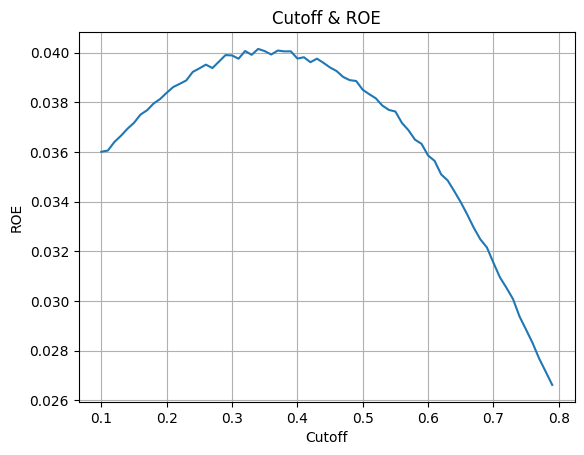

Train: [      5       6       7 ... 1078512 1078516 1078518] Test: [      0       1       2 ... 1078520 1078521 1078522]
Train: [      0       1       2 ... 1078520 1078521 1078522] Test: [      5       6       7 ... 1078512 1078516 1078518]
cut_off [0.1]
mean roe [0.03553059102466122]
Train: [      2       3       4 ... 1078513 1078520 1078521] Test: [      0       1       5 ... 1078518 1078519 1078522]
Train: [      0       1       5 ... 1078518 1078519 1078522] Test: [      2       3       4 ... 1078513 1078520 1078521]
cut_off [0.11]
mean roe [0.03603370130857321]
Train: [      1       2       3 ... 1078514 1078516 1078519] Test: [      0       6      10 ... 1078520 1078521 1078522]
Train: [      0       6      10 ... 1078520 1078521 1078522] Test: [      1       2       3 ... 1078514 1078516 1078519]
cut_off [0.12]
mean roe [0.03647882692259352]
Train: [      1       3       5 ... 1078518 1078519 1078522] Test: [      0       2       4 ... 1078516 1078520 1078521]
Train: [      0 

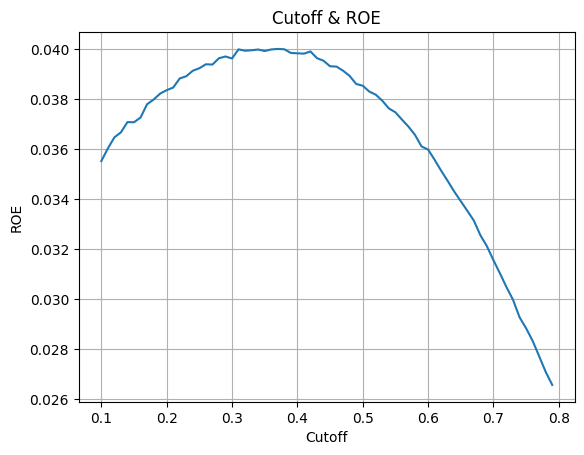

Train: [      0       1       2 ... 1078510 1078517 1078518] Test: [      7      10      11 ... 1078520 1078521 1078522]
Train: [      7      10      11 ... 1078520 1078521 1078522] Test: [      0       1       2 ... 1078510 1078517 1078518]
cut_off [0.1]
mean roe [0.03596667984286621]
Train: [      0       1       2 ... 1078518 1078519 1078522] Test: [      3       4       6 ... 1078517 1078520 1078521]
Train: [      3       4       6 ... 1078517 1078520 1078521] Test: [      0       1       2 ... 1078518 1078519 1078522]
cut_off [0.11]
mean roe [0.036488902971482315]
Train: [      1       4       5 ... 1078517 1078519 1078522] Test: [      0       2       3 ... 1078518 1078520 1078521]
Train: [      0       2       3 ... 1078518 1078520 1078521] Test: [      1       4       5 ... 1078517 1078519 1078522]
cut_off [0.12]
mean roe [0.036515349222408094]
Train: [      3       5       7 ... 1078518 1078519 1078520] Test: [      0       1       2 ... 1078511 1078521 1078522]
Train: [      

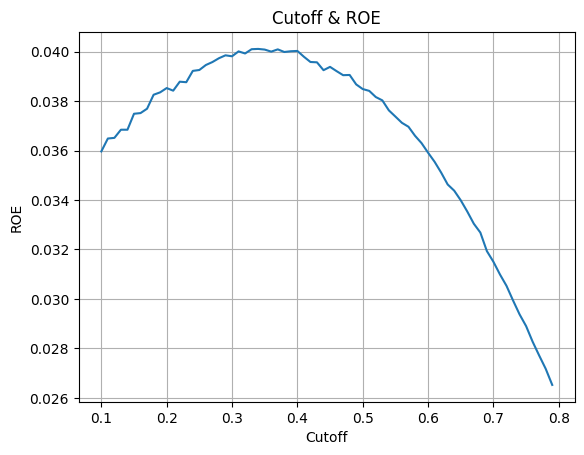

In [ ]:
result_lgbm_df = pd.DataFrame()

for i in range(1,21):
    df_lgbm = pipeline('lgbm')

    df_lgbm['Iteration'] = i

    result_lgbm_df = pd.concat([result_lgbm_df, df_lgbm], ignore_index=True)

result_lgbm_df.to_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/yes20_lgbm_df.csv', index=False)

In [ ]:
result_lgbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Cut Off:    350 non-null    float64
 1   ROE:        350 non-null    float64
 2   Accuracy:   350 non-null    float64
 3   Precision:  350 non-null    float64
 4   Recall:     350 non-null    float64
 5   F1:         350 non-null    float64
 6   Iteration   350 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 19.3 KB


In [ ]:
df = result_lgbm_df.copy()

# Group the DataFrame by 'Iteration' and find the index of the maximum 'ROE:' value within each group
max_roe_indices = df.groupby('Iteration')['ROE:'].idxmax()

# Use the index to reorder the DataFrame
df_sorted = df.loc[max_roe_indices].reset_index(drop=True)
df_sorted = df_sorted.sort_values(by='ROE:', ascending=False)
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

,Cut Off:,ROE:,Accuracy:,Precision:,Recall:,F1:,Iteration
0,0.37,0.040253,0.555993,0.280147,0.802888,0.415363,1
1,0.34,0.040146,0.523036,0.269698,0.836105,0.407841,3
2,0.34,0.040113,0.522866,0.269619,0.836072,0.407746,5
3,0.38,0.040095,0.566691,0.283406,0.788823,0.416996,2
4,0.37,0.040016,0.555911,0.279897,0.801524,0.414907,4


###XGB_Validation

In [ ]:
result_xgb_df = pd.DataFrame()

for i in range(1,21):
    df_xgb = pipeline('xgb')

    df_xgb['Iteration'] = i

    result_xgb_df = pd.concat([result_xgb_df, df_xgb], ignore_index=True)

result_xgb_df.to_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/yes20_xgb_df.csv', index=False)

In [ ]:
df = result_xgb_df.copy()

# Group the DataFrame by 'Iteration' and find the index of the maximum 'ROE:' value within each group
max_roe_indices = df.groupby('Iteration')['ROE:'].idxmax()

# Use the index to reorder the DataFrame
df_sorted = df.loc[max_roe_indices].reset_index(drop=True)
df_sorted = df_sorted.sort_values(by='ROE:', ascending=False)
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

### OUt of Sample Test

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def out_of_sample_test_pipeline(cut_off_values=None):

    data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/test_df.csv')
    #data.drop(['loan_status', 'ym', 'DATE_x', 'grade', 'sub_grade', 'Unnamed: 0','DATE_y', 'fico_range_low',
    data.drop(['emp_length'], axis=1, inplace=True)

    selected_variables = [
        'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'fico_range_high',
        'mths_since_last_delinq', 'revol_bal', 'revol_util', 'total_acc', 'acc_open_past_24mths',
        'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_il_tl',
        'num_rev_accts', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
        'total_il_high_credit_limit', 'GS2', 'UNRATE', 'term', 'collections_12_mths_ex_med',
        'chargeoff_within_12_mths', 'tax_liens' ,'id','defaulter'
    ]
    data = data[selected_variables]

    raw_data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/lending_club_2020_test.csv')
    raw_data['defaulter'] = raw_data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else (1 if x != 'Current' else None))
    raw_data.dropna(subset=['defaulter'], inplace=True)

    # 범주형 변수, 원핫인코딩
    categorical_columns = data.select_dtypes(include=['object']).columns
    one_hot_encoder = OneHotEncoder()
    dummy_variables = one_hot_encoder.fit_transform(data[categorical_columns])
    dummy_df = pd.DataFrame(dummy_variables.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns))
    data_final = pd.concat([data, dummy_df], axis=1)

    # 상환 기록을 추적할 id 준비
    a = data['id']
    data_final['id'] = a
    add_column = data['defaulter']
    data_final['defaulter'] = add_column

    # 최종 훈련 데이터 준비 완료.
    X = data_final.drop('defaulter', axis=1)
    y = data_final['defaulter']

    model = LGBMClassifier(learning_rate=0.1, metric='binary_logloss', max_depth=-1, min_child_samples=560, num_leaves=1995,
                           n_estimators=100, force_col_wise=True, scale_pos_weight=4.170821627484008, verbosity=-1)

    # 실수 변수 : MinMax Scaling
    mod = make_pipeline(MinMaxScaler(), model)
    mod.fit(X, y)

    if cut_off_values is None:
        cut_off_values = 0.5
    else:
        cut_off_values = cut_off_values

    # 컷오프를 기준으로 분류
    probability = mod.predict_proba(X)[:, 1]
    cutoff = cut_off_values
    prediction = (probability >= cutoff).astype(int)

    # 평가 지표 계산
    accuracy = accuracy_score(y, prediction)
    precision = precision_score(y, prediction)
    recall = recall_score(y, prediction)
    f1 = f1_score(y, prediction)
    confusion = confusion_matrix(y, prediction)

    # 모든 분류결과에 기존 존재하던 ID 부여 : (전체 X 대상)
    result = pd.DataFrame({'id': data_final['id'], 'defaulter_prediction': prediction, 'defaulter_probability': probability})

    # ID를 기준으로, 분류결과 + raw_data
    merged_df = pd.merge(result, raw_data, on='id', how='inner')
    merged_df['term'] = merged_df['term'].str.extract('(\d+)').astype(float)

    # all_loan : 대출 승인된 모든 경우 : (분류기가 모두 '비부도' 라고 예측한 경우, TP + FN)
    all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                         (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

    # 기간 계산
    all_loan['last_pymnt_d'] = pd.to_datetime(all_loan['last_pymnt_d'], format='%b-%Y')
    all_loan['issue_d'] = pd.to_datetime(all_loan['issue_d'], format='%b-%Y')
    all_loan['paid_months'] = (all_loan['last_pymnt_d'] - all_loan['issue_d']) / pd.Timedelta(days=30)
    all_loan.loc[all_loan['paid_months'] == 0, 'paid_months'] = 1

    # 평균 상환기간 계산 & 연 단위 변경
    avg_paid_year = all_loan['paid_months'].mean() / 12

    # ROE 계산
    roe = ((all_loan['total_pymnt'].sum() - all_loan['funded_amnt'].sum()) / avg_paid_year) / all_loan['funded_amnt'].sum()

    print('cut_off:', cut_off_values)
    print('roe:', roe)
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    print('f1:', f1)
    print('confusion:', confusion)

    figure_df = pd.DataFrame({'Cut Off:': [cut_off_values],
                              'ROE:': [roe],
                              'Accuracy:': [accuracy],
                              'Precision:': [precision],
                              'Recall:': [recall],
                              'F1:': [f1],
                              })

    return figure_df


In [ ]:
out_of_sample_test_pipeline(cut_off_values=0.34)

cut_off: 0.34
roe: 0.05948270612548636
accuracy: 0.584208367799473
precision: 0.318291073834173
recall: 0.9749037340587134
f1: 0.47990164282223885
confusion: [[282241 295529]
 [  3552 137983]]


,Cut Off:,ROE:,Accuracy:,Precision:,Recall:,F1:
0,0.34,0.059483,0.584208,0.318291,0.974904,0.479902
